In [ ]:
from IPython.display import clear_output
! pip install tf_explain
clear_output()

In [2]:
# common
import os
import time
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi

# Data
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Data Viz
import matplotlib.pyplot as plt

# Model 
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPooling2D, Conv2DTranspose
from keras.layers import Activation
from keras.layers import PReLU
from keras.layers import BatchNormalization

# Callbacks 
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM

# Metrics
from keras.metrics import MeanIoU

# **Data**

In [3]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]
    
    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
    
    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img
    
    return images

In [4]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [5]:
SIZE = 256

In [6]:
root_path = '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'
classes = sorted(os.listdir(root_path))
classes

['benign', 'malignant', 'normal']

In [7]:
single_mask_paths = sorted([sorted(glob(root_path + name + "/*mask.png")) for name in classes])
double_mask_paths = sorted([sorted(glob(root_path + name + "/*mask_1.png")) for name in classes])

In [8]:
image_paths = []
mask_paths = []
for class_path in single_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask','')
        image_paths.append(img_path)
        mask_paths.append(path)

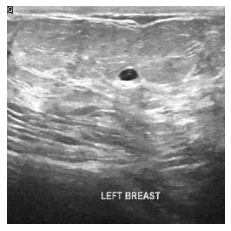

In [9]:
show_image(load_image(image_paths[0], SIZE))

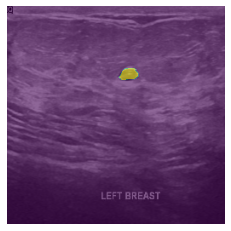

In [10]:
show_mask(load_image(image_paths[0], SIZE), load_image(mask_paths[0], SIZE)[:,:,0], alpha=0.6)

## **Approach**

Below here I have explained my strategy to tackel the multiple mask Images.

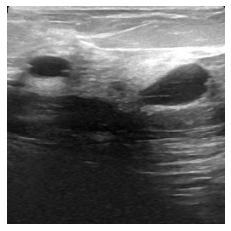

In [11]:
show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))

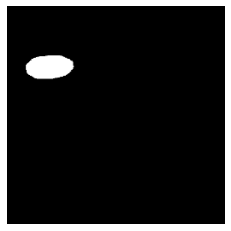

In [12]:
show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE))

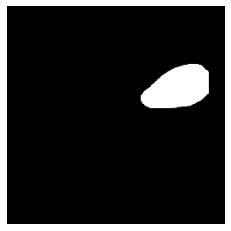

In [13]:
show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', SIZE))

I don't want the data this way, as both the masks belongs to the same class. A better idea can be to merge both these images

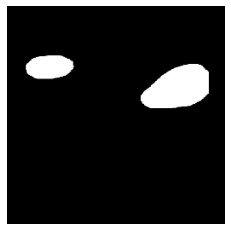

In [14]:
img = np.zeros((1,SIZE,SIZE,3))
mask1 = load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE)
mask2 = load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', SIZE)

img = img + mask1 + mask2
img = img[0,:,:,0]
show_image(img, cmap='gray')

We first merged them and them simple used the 1st channel because that is enough.

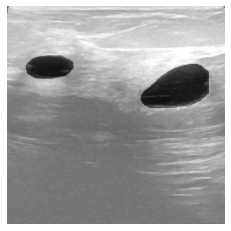

In [15]:
show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, cmap='binary', alpha=0.4)
plt.axis('off')
plt.show()

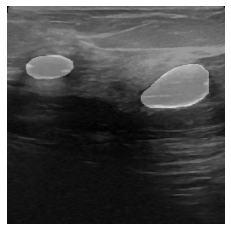

In [16]:
show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, cmap='gray', alpha=0.4)
plt.axis('off')
plt.show()

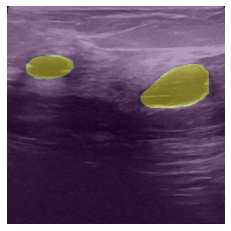

In [17]:
show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, alpha=0.4)
plt.axis('off')
plt.show()

This is how it looks with different cmaps. But you can drop them as then are very less in number (i.e 16) and this will not affect training much.

## **Data Work**

In [18]:
images = load_images(image_paths, SIZE)
masks = load_images(mask_paths, SIZE, mask=True)

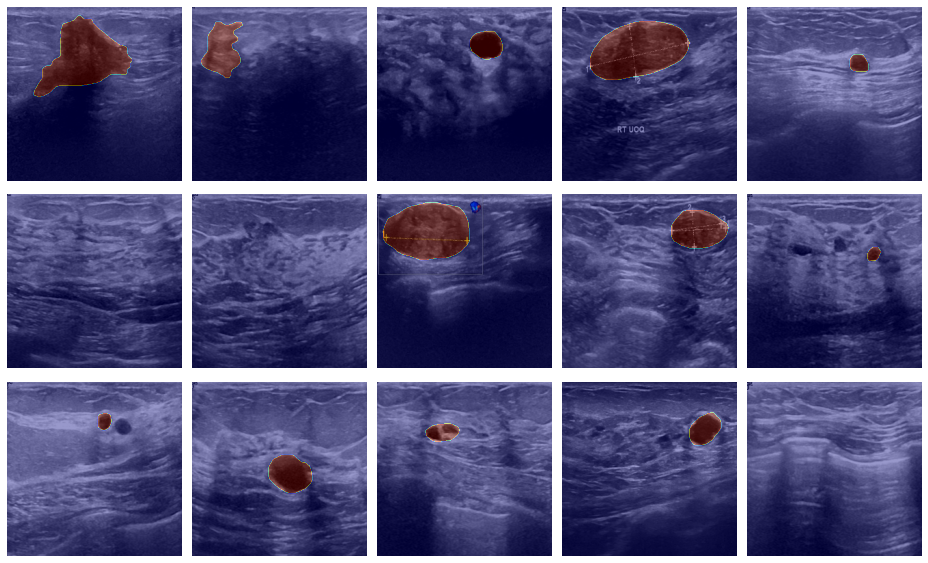

In [19]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='jet')
plt.tight_layout()
plt.show()

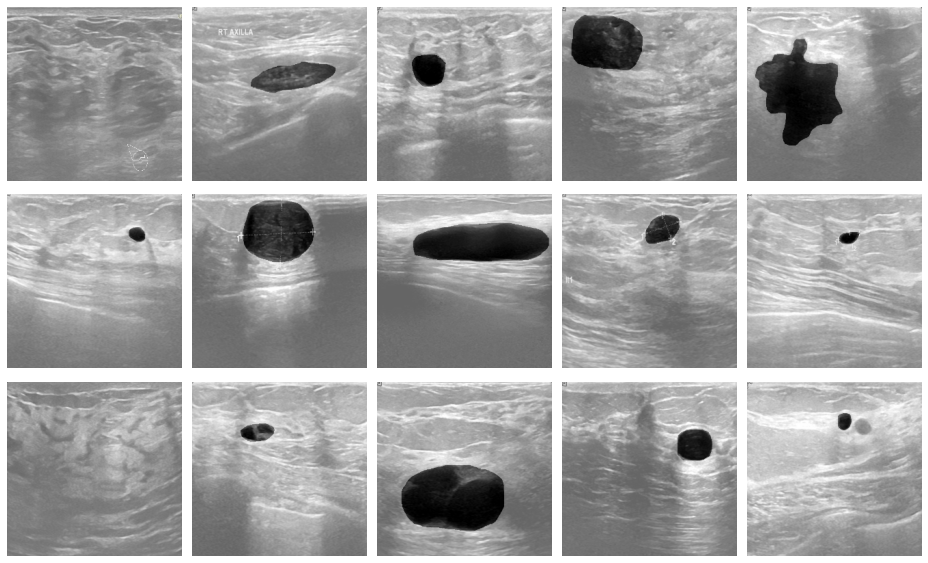

In [20]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='binary')
plt.tight_layout()
plt.show()

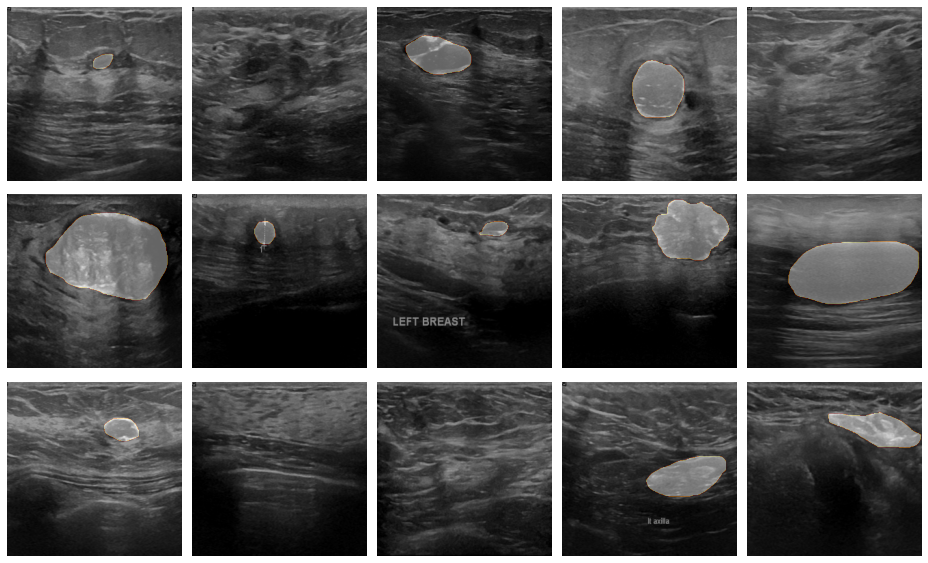

In [21]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='afmhot')
plt.tight_layout()
plt.show()

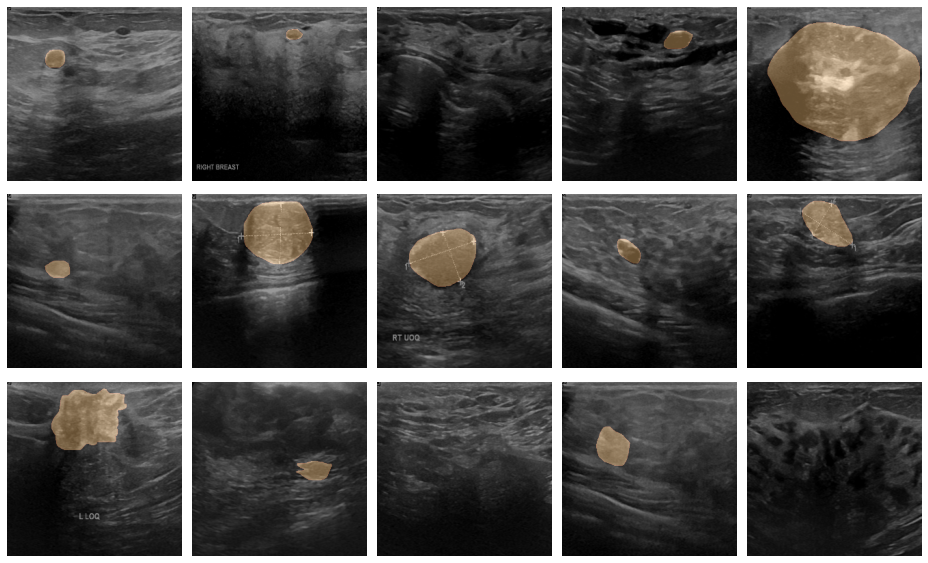

In [22]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='copper')
plt.tight_layout()
plt.show()

# **Encoder**

In [23]:
class EncoderBlock(Layer):
    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.drop = Dropout(rate)
        self.pool = MaxPooling2D(pool_size=(2, 2))
        self.res = ResidualBlock(filters)
        
    def call(self, X):
        x = self.res(X)
        #x = self.drop(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

# **Residual Block**

In [24]:
from keras.layers import ReLU
class ResidualBlock(Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.filters = filters
        
        self.c1 = Conv2D(self.filters, kernel_size=3, strides=1, padding='same')
        self.b1 = BatchNormalization()
        self.r1 = ReLU()
        
        self.c2 = Conv2D(self.filters, kernel_size=3, strides=1, padding='same')
        self.b2 = BatchNormalization()
        
        self.c3 = Conv2D(self.filters,(1,1), padding='same', strides=(1,1))
        self.r2 = ReLU()
        
    def call(self, X):
        out = self.c1(X)
        out = self.b1(out)
        out = self.r1(out)
        
        out = self.c2(out)
        out = self.b2(out)
        
        if X.get_shape()[-1] != out.get_shape()[-1]:
            X = self.c3(X)
            
        out = Add()([X, out])
        out = self.r2(out)

        return out
    
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

# **Decoder**

In [25]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D((2, 2))
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

# **Attention Gate**

In [26]:
class AttentionGate(Layer):

    def __init__(self, filters, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)
        self.filters = filters

        self.normal = Conv2D(filters, kernel_size=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=1, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.one = Conv2D(1,(1,1),(1,1), padding="same")
        
        self.relu = Activation('relu')
        self.sigmoid = Activation('sigmoid')
        
        self.learn = Conv2D(filters, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D((2,2))
        

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        
        x = self.relu(x)
        x = self.one(x)
        x = self.sigmoid(x)
        
        x = self.resample(x)
        x = self.learn(x)
        f = Multiply()([x, skip_X])
        
        return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters
        }

# **Custom Callback**

In [27]:
class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
        if epochs % 10 == 0:
            id = np.random.randint(200)
            exp = GradCAM()
            image = images[id]
            mask = masks[id]
            pred_mask = self.model.predict(image[np.newaxis,...])
            cam = exp.explain(
                validation_data=(image[np.newaxis,...], mask),
                class_index=1,
                layer_name='Attention4',
                model=self.model
            )

            plt.figure(figsize=(10,5))

            plt.subplot(1,3,1)
            plt.title("Original Mask")
            show_mask(image, mask, cmap='copper')

            plt.subplot(1,3,2)
            plt.title("Predicted Mask")
            show_mask(image, pred_mask, cmap='copper')

            plt.subplot(1,3,3)
            show_image(cam,title="GradCAM")

            plt.tight_layout()
            plt.show()

# **Evaluation**

In [ ]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

In [ ]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title("Model Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.title("Model Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.title("Model IoU")
plt.plot(iou, label="Training")
plt.plot(val_iou, label="Validtion")
plt.legend()
plt.grid()

plt.show()

Suprisingly the results on **Validation Data** are **way better** than the results on **Trainind Data** on **IoU**, this may indicate that the **model can perform way better** than what it can do at the current point. The **Loss is not Perfect** it increases in the last but the model constructions are loooking perfect as this point, that's why **I believe in what I see**. This model seems promising, let's try it on some Images.

In [ ]:
# saved_model = tf.keras.models.load_model('/kaggle/input/breast-cancer-detection-unet/BreastCancerAttentionUNet.h5')

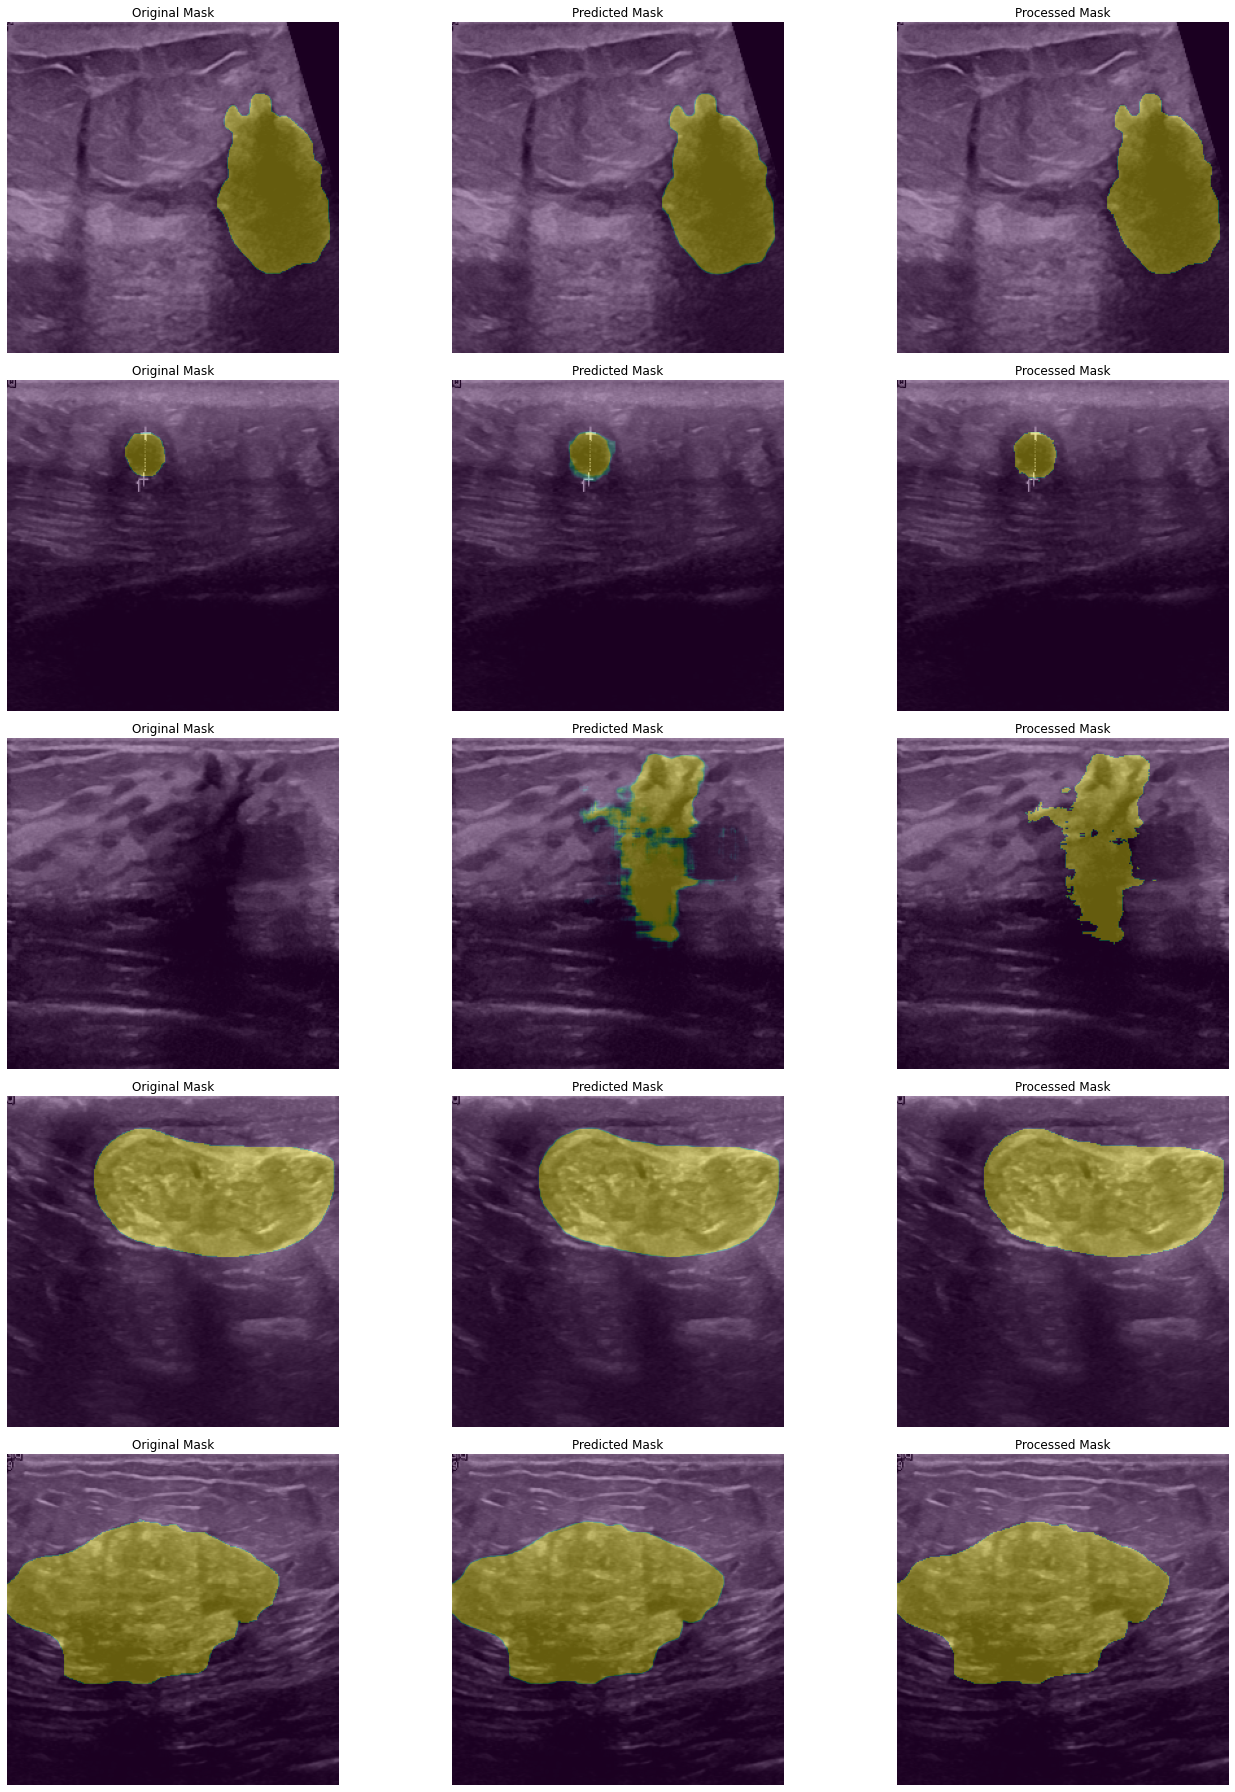

In [39]:
plt.figure(figsize=(20,25))
n=0
for i in range(1,(5*3)+1):
    plt.subplot(5,3,i)
    if n==0:
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        pred_mask = model.predict(image[np.newaxis,...])

        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()

The results totally convincing. If you have any suggestions please let me know 👍. **Thanks !!**